<a href="https://colab.research.google.com/github/cherylktt/tensorflow/blob/main/08_introduction_do_nlp_in_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to NLP Fundamentals in TensorFlow

NLP has the goal of deriving information out of natural language (could be sequences of text or speech). Another common term for NLP problems is sequence to sequence problems (seq2seq).

## Check for GPU

In [ ]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-2ab167f3-2b6d-3523-5f67-378f77c47bb5)


## Get helper functions

In [ ]:
!wget https://raw.githubusercontent.com/cherylktt/tensorflow/main/helper_functions.py

--2022-04-27 15:55:16--  https://raw.githubusercontent.com/cherylktt/tensorflow/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14532 (14K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  14.19K  --.-KB/s    in 0.001s  

2022-04-27 15:55:17 (24.8 MB/s) - ‘helper_functions.py’ saved [14532/14532]



## Get a text dataset

The dataset we're going to be using is Kaggle's introduction to NLP dataset (text samples of Tweets labelled as disaster of not disaster).

See the original source here: https://www.kaggle.com/competitions/nlp-getting-started

In [ ]:
from helper_functions import unzip_data
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

# Unzip data
unzip_data("nlp_getting_started.zip")

--2022-04-27 15:55:25--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.97.128, 108.177.125.128, 142.250.157.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.97.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.007s  

2022-04-27 15:55:25 (89.0 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



## Visualising a text dataset

To visualise our text samples, we first have to read them in, one way to do so would be to use [Python](https://realpython.com/read-write-files-python/).

Another way is to use `pandas` or [TensorFlow](https://www.tensorflow.org/tutorials/load_data/text).

In [ ]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


> 1 is for disater, 0 is for not disaster.

In [ ]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [ ]:
# What does the test dataframe look like?
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
# How many examples of each class?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

> If your data is not balanced, consider following this guide: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

In [ ]:
# How many total samples?
len(train_df), len(test_df)

(7613, 3263)

In [ ]:
# Let's visualise some random training examples
import random
random_index = random.randint(0, len(train_df)-5) # create random indexes not higher than the total number of samples
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaaster)")
  print(f"Text: {text}\n")
  print("---\n")

Target: 0 (not real disaaster)
Text: Fire Meet Gasoline always gotta get played twice lol

---

Target: 0 (not real disaaster)
Text: We all carry these things inside that no one else can see. They hold us down like anchors they drown us out at sea.

---

Target: 0 (not real disaaster)
Text: @BV Bloomberg will publish anything negative to try and derail public support in favor of the #IranDeal.

---

Target: 1 (real disaster)
Text: #coppednews Haunting memories drawn by survivors http://t.co/Wx11d69gEZ

---

Target: 0 (not real disaaster)
Text: How to Freeze Fruits and Veggies
http://t.co/MET0mtpr3S

---



### Split data into training and validation sets

In [ ]:
from sklearn.model_selection import train_test_split

# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1,
                                                                            random_state=42)

In [ ]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [ ]:
# Check out the first 10 examples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object), array([0, 

## Converting text into numbers

When dealing with a text problem, one of the first things you'll have to do before you can build a model is to convert your text to numbers. There are a few ways to this, namely:

* **Tokenization** - straight mapping from token to number (can be modelled but quickly gets too big)
* **Embedding** - richer representation of relationships between tokens (can limit size + can be learned)

Pre-trained word embeddings can be found here:
* [Word2vec embeddings](http://jalammar.github.io/illustrated-word2vec/)
* [GloVe embeddings](https://nlp.stanford.edu/projects/glove/)
* [TensorFlow Hub](https://tfhub.dev/s?module-type=text-embedding)

### Text vectorization (tokenization)

In [ ]:
train_sentences[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

# Use the default TextVectorization parameters
text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary (automatically add <OOV>)
                                    standardize="lower_and_strip_punctuation",
                                    split="whitespace",
                                    ngrams=None, # create groups of n-words?
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=None, # how long do you want your sequences to be?
                                    pad_to_max_tokens=False)

The `TextVectorization` layer takes the following parameters:

* `max_tokens` - The maximum number of words in your vocabulary (e.g. 20000 or the number of unique words in your text), includes a value for OOV (out of vocabulary) tokens.
* `standardize` - Method for standardizing text. Default is `"lower_and_strip_punctuation"` which lowers text and removes all punctuation marks.
* `split` - How to split text, default is `"whitespace"` which splits on spaces.
* `ngrams` - How many words to contain per token split, for example, `ngrams=2` splits tokens into continuous sequences of 2.
* `output_mode` - How to output tokens, can be `"int"` (integer mapping), `"binary"` (one-hot encoding), `"count"` or `"tf-idf"`. See documentation for more.
* `output_sequence_length` - Length of tokenized sequence to output. For example, if `output_sequence_length=150`, all tokenized sequences will be 150 tokens long.
* `pad_to_max_tokens` - Defaults to `False`, if `True`, the output feature axis will be padded to `max_tokens` even if the number of unique tokens in the vocabulary is less than `max_tokens`.

In [ ]:
train_sentences[0].split(), len(train_sentences[0].split())

(['@mogacola', '@zamtriossu', 'i', 'screamed', 'after', 'hitting', 'tweet'], 7)

In [ ]:
# Find the average number of tokens (words) in the training tweets
round(sum([len(i.split()) for i in train_sentences]) / len(train_sentences))

15

In [ ]:
# Set up text vectorization variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how many words from a Tweet does a model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [ ]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [ ]:
# Create a sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [ ]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text: {random_sentence}\n")
print(f"Vectorized version: {text_vectorizer([random_sentence])}")

Original text: U.S.PACIFIC COMMAND.
I can see it!
They gave their all in the peace unity festival
It disappears when freedom
A Violent Storm hit Sea

Vectorized version: [[7120 5953    8   71   99   15   64  949  131   44    4    2  675 4343
  2459]]


In [ ]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary() # get all of the unique words in our training data
top_5_words = words_in_vocab[:5] # get the most common words
bottom_5_words = words_in_vocab[-5:] # get the least common words

print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"5 most common words: {top_5_words}")
print(f"5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
5 most common words: ['', '[UNK]', 'the', 'a', 'in']
5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### Creating an Embedding using an Embedding Layer

To make our embedding, we're going to use TensorFlow's [embedding layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding).

The parameters we care most about for our embedding layer:
* `input_dim` - the size of our vocabulary
* `output_dim` - the size of the output embedding vector (e.g. a value of 100 would mean each token gets represented by a vector 100 long)
* `input_length` - length of the sequences being passed to the embedding layer

In [ ]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # input shape
                             output_dim=128, # output shape
                             embeddings_initializer="uniform",
                             input_length=max_length # how long is each input
                             )
embedding

In [ ]:
# Get a random sentence from the training set
random_sentence = random.choice(train_sentences)
print(f"Original text: {random_sentence}")
print(f"Embedded version: ")

# Embed the random sentence (turn positive integers into dense vectors of fixed size)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text: http://t.co/kG5pLkeDhr WRAPUP 2-U.S. cable TV companies' shares crushed after Disney disappoints http://t.co/QeIhvn3DNQ
Embedded version: 


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.04230822, -0.0450935 , -0.02981206, ...,  0.023426  ,
          0.0274842 , -0.04010003],
        [-0.02445437,  0.01328648,  0.00681914, ..., -0.03546847,
         -0.01359737,  0.02663015],
        [-0.0473414 , -0.00272267,  0.02374319, ..., -0.02527031,
         -0.02917   ,  0.01515373],
        ...,
        [-0.03670188, -0.00918275, -0.00819641, ...,  0.02483923,
         -0.0233631 ,  0.03163451],
        [-0.03670188, -0.00918275, -0.00819641, ...,  0.02483923,
         -0.0233631 ,  0.03163451],
        [-0.03670188, -0.00918275, -0.00819641, ...,  0.02483923,
         -0.0233631 ,  0.03163451]]], dtype=float32)>

In [ ]:
# Check out a single token's embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([ 0.04230822, -0.0450935 , -0.02981206, -0.03045708, -0.00662007,
         0.03240019,  0.03749087,  0.04358138, -0.00071908,  0.02672647,
         0.03798341, -0.02632812,  0.01698733, -0.04833702, -0.00193607,
         0.04162024,  0.01828239, -0.03445927, -0.01912199,  0.03571204,
        -0.02880859,  0.04653515, -0.00132449,  0.04785773,  0.00580963,
        -0.0005294 ,  0.04604502, -0.03026013,  0.00423077,  0.02281907,
         0.03253833,  0.02371725,  0.00589844,  0.00589439, -0.02740568,
        -0.02481283,  0.00169326,  0.0111218 ,  0.02670814, -0.02246195,
         0.02316317,  0.0457282 ,  0.03819885, -0.01906105,  0.01653633,
         0.0182314 , -0.01022931, -0.04965733, -0.03723959, -0.02515097,
        -0.01053071, -0.02818724,  0.0148036 ,  0.04741443,  0.02735785,
        -0.0345692 , -0.01525587,  0.00387101,  0.02428268,  0.00997975,
         0.03362663, -0.04641443,  0.03158811,  0.02430281, -0.02532505,
  

## Modelling a text dataset (running a series of experiments)

We will be doing a series of modelling experiments:
* `model_0` - Naive Bayes with TF-IDF encoder (baseline)
* `model_1` - Feed-forward neural network (dense model)
* `model_2` - LSTM Recurrent Neural Netwrok (RNN)
* `model_3` - GRU Recurrent Neural Netwrok (RNN)
* `model_4` - Bidirectional-LSTM Recurrent Neural Netwrok (RNN)
* `model_5` - 1D Convolutional Neural Network (CNN)
* `model_6` - TensorFlow Hub Pretrained Feature Extractor
* `model_7` - TensorFlow Hub Pretrained Feature Extractor (10% of data)

Use the [scikit-learn machine learning map](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) to decide which model to use to build a baseline.

How are we going to approach all of these? We will use the standard steps in modelling with TensorFlow:
1. Create a model
2. Build a model
3. Fit a model
4. Evaluate out model

### Model 0: Getting a baseline

As with all machine learning modelling experiments, it's important to create a baselin model so you've got a benchmark for future experiments to build upon. To create our baseline, we'll use Sklearn's Mutlnomial Naive Bayes using the TF-IDF formula to convert words to numbers.

**Note:** It's common practice to use non-DL algorithms as a baseline because of their speed and then later using DL to see if you can improve upon them.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evaluate our baseline model
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [ ]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [ ]:
val_labels[:20]

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [ ]:
# Find the baseline accuracy score using sklearn
from sklearn.metrics import accuracy_score
baseline_score = accuracy_score(val_labels, baseline_preds)
print(f"Our baseline model has an accuracy score of: {baseline_score*100:.2f}%")

Our baseline model has an accuracy score of: 79.27%


### Creating an evaluation function for our model experiments

We could evaluate all of our model's predictions with different metrics every time, however, this will be cumbersome and could easily be fixed with a function. Let's create one to compare our model's predictions with the truth labels using the following metrics:
* Accuracy
* Precision
* Recall
* F1-score

For a deep overview of many different evaluation metrics, see the [Sklearn documentation](https://scikit-learn.org/stable/modules/model_evaluation.html)

In [ ]:
# Function to evalute model's predictions using accuracy, precision, recall, f1_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array
  
  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100

  # Calcaulte model precision, precision and f1-score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                   "f1": model_f1,
                   "precision": model_precision,
                   "recall": model_recall}
  return model_results

In [ ]:
# Get baseline results
baseline_results = calculate_results(val_labels, baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

### Model 1: A simple dense model

In [ ]:
# Create a tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create a directory to save tensorboard logs
SAVE_DIR = "model_logs"

In [ ]:
# Build model with the Functional API
from tensorflow import keras
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string) # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numberized inputs
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x) # create the output layer, want binary output so use sigmoid activation
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

In [ ]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [ ]:
# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Fit the model
model_1_history = model_1.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_1_dense")])

Saving TensorBoard log files to model_logs/model_1_dense/20220427-155609
Epoch 1/5
215/215 [==============================] - 5s 21ms/step - loss: 0.6112 - accuracy: 0.6881 - val_loss: 0.5333 - val_accuracy: 0.7625
Epoch 2/5
215/215 [==============================] - 6s 26ms/step - loss: 0.4400 - accuracy: 0.8210 - val_loss: 0.4663 - val_accuracy: 0.7822
Epoch 3/5
215/215 [==============================] - 5s 25ms/step - loss: 0.3459 - accuracy: 0.8615 - val_loss: 0.4575 - val_accuracy: 0.7913
Epoch 4/5
215/215 [==============================] - 6s 27ms/step - loss: 0.2834 - accuracy: 0.8892 - val_loss: 0.4596 - val_accuracy: 0.7795
Epoch 5/5
215/215 [==============================] - 6s 27ms/step - loss: 0.2369 - accuracy: 0.9111 - val_loss: 0.4861 - val_accuracy: 0.7940


In [ ]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 2ms/step - loss: 0.4861 - accuracy: 0.7940


[0.4860610365867615, 0.7939632534980774]

In [ ]:
# Look at the first 10 predictions
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:10]

array([[0.29611415],
       [0.7862656 ],
       [0.99751806],
       [0.07935214],
       [0.07474983],
       [0.93195415],
       [0.90415937],
       [0.99344134],
       [0.9532739 ],
       [0.19955146]], dtype=float32)

In [ ]:
# Evaluate the predictions
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs)) # convert probabilities to label format

model_1_results = calculate_results(val_labels, model_1_preds)
model_1_results

{'accuracy': 79.39632545931758,
 'f1': 0.7899134672804106,
 'precision': 0.8031272377768599,
 'recall': 0.7939632545931758}

In [ ]:
# Functionize the above steps
def evaluate_predictions(model, test_data, y_true):
  model_pred_probs = model.predict(test_data)
  model_preds = tf.squeeze(tf.round(model_pred_probs))
  return calculate_results(y_true, model_preds)

In [ ]:
evaluate_predictions(model_1, val_sentences, val_labels)

{'accuracy': 79.39632545931758,
 'f1': 0.7899134672804106,
 'precision': 0.8031272377768599,
 'recall': 0.7939632545931758}

In [ ]:
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([ True,  True, False,  True])

## Visualizing learned embeddings

In [ ]:
# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [ ]:
# Model 1 summary
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [ ]:
# Get the weight matrix of embedding layer (learned patterns)
# These are the numerical representations of each token in our training data, which have been learned for ~5 epochs
embed_weights = model_1.get_layer("embedding").get_weights()[0]
print(embed_weights.shape) # should be same size as vocab size and embedding_dim (output_dim of embedding layer)

(10000, 128)


Now we've got the embedding matrix our model has learned to represent our tokens, let's see how we can visualise it.

To do so, TensorFlow has a handy tool called [Projector](https://projector.tensorflow.org). TensorFlow also has a handy guide on [word embeddings](https://www.tensorflow.org/text/guide/word_embeddings).

In [ ]:
# Create embedding files (we got this from TensorFlow's word embeddings documentation)
import io
out_v = io.open("vectors.tsv", "w", encoding="utf-8")
out_m = io.open("metadata.tsv", "w", encoding="utf-8")

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write("\t".join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [ ]:
# Download files from Colab to Projector
try:
  from google.colab import files
  files.download("vectors.tsv")
  files.download("metadata.tsv")
except Exception:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Good read to learn more about embeddings: http://jalammar.github.io/illustrated-word2vec/

## Recurrent Neural Networks (RNN's)

RNN's are useful for sequence data.

The premise of a recurrent neural network is to use the representation of a previous input to aid the representation of a later input.

> For an overview of the internals of a recurrent nerual network, see the following resources:
- [MIT's sequence modelling lecture](https://youtu.be/QvkQ1B3FBqA?list=PLtBw6njQRU-rwp5__7C0oIVt26ZgjG9NI)
- [Chris Olah's intro to LSTMS](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
- [Andrej Karpathy's The Unreasonable Effectiveness of RNN](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)

Type of RNN's:
* **LSTM (long short-term memory)** - default RNN layer for sequence problems
* **GRU (gated recurrent unit)** - performs very similar to LSTM
* **Bidirectional LSTM (goes forward and backwards on sequence)** - good for sequences which may benefit from passing forward and backwards (e.g. translation or longer passages of text)

### Model 2: LSTM

LSTM is short for long short term memory (one of the most popular LSTM cells).

Our structure of an RNN typically looks like this:
```
Input (text) -> Tokenize -> Embedding -> Layers (RNNs/dense) -> Output (label probability)
```

In [ ]:
# Create an LSTM model
from tensorflow.keras import layers
model_2_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_2")

inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = model_2_embedding(x)
# print(x.shape)
# x = layers.LSTM(units=64, return_sequences=True)(x) # when you're stacking RNN cells together, you need to set return_sequences=True to return vector for each word
# print(x.shape)
x = layers.LSTM(units=64)(x) # return vector for each sequence
# print(x.shape)
# x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

LSTM input requires a 3-dimensional vector with shape [batch, timesteps, feature].

In [ ]:
# Get a summary
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
____________________________________________

In [ ]:
# Compile the model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Fit the model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "model_2_LSTM")])

Saving TensorBoard log files to model_logs/model_2_LSTM/20220427-155657
Epoch 1/5
215/215 [==============================] - 9s 29ms/step - loss: 0.5126 - accuracy: 0.7473 - val_loss: 0.4571 - val_accuracy: 0.7769
Epoch 2/5
215/215 [==============================] - 6s 27ms/step - loss: 0.3196 - accuracy: 0.8720 - val_loss: 0.4761 - val_accuracy: 0.7900
Epoch 3/5
215/215 [==============================] - 6s 27ms/step - loss: 0.2230 - accuracy: 0.9180 - val_loss: 0.5167 - val_accuracy: 0.7677
Epoch 4/5
215/215 [==============================] - 6s 27ms/step - loss: 0.1592 - accuracy: 0.9412 - val_loss: 0.6867 - val_accuracy: 0.7559
Epoch 5/5
215/215 [==============================] - 7s 31ms/step - loss: 0.1160 - accuracy: 0.9561 - val_loss: 0.8855 - val_accuracy: 0.7572


In [ ]:
# Calculate model 2 results
model_2_results = evaluate_predictions(model_2, val_sentences, val_labels)
model_2_results

{'accuracy': 75.7217847769029,
 'f1': 0.7548067945124027,
 'precision': 0.7588431452858484,
 'recall': 0.7572178477690289}

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

### Model 3: GRU

Another popular and effective RNN component is the GRU or gated recurrent unit. The GRU cell has similar features to an LSTM cell but has less parameters.

Good guide on GRU's: https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21

In [ ]:
# Build an RNN using the GRU cell
from tensorflow.keras import layers
model_3_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_3")

inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = model_3_embedding(x)
# x = layers.GRU(units=64, return_sequences=True)(x) # if you want to stack recurrent layers on top of each other, you need return_sequences=True
# x = layers.LSTM(64, return_sequences=True)(x)
x = layers.GRU(64)(x)
# x = layers.GlobalAveragePooling1D()(x)
# x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [ ]:
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_3 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_____________________________________________

In [ ]:
# Compile the model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Fit the model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "model_3_GRU")])

Saving TensorBoard log files to model_logs/model_3_GRU/20220427-144557
Epoch 1/5
215/215 [==============================] - 5s 12ms/step - loss: 0.5291 - accuracy: 0.7319 - val_loss: 0.4764 - val_accuracy: 0.7822
Epoch 2/5
215/215 [==============================] - 2s 10ms/step - loss: 0.3146 - accuracy: 0.8683 - val_loss: 0.4727 - val_accuracy: 0.7874
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.2158 - accuracy: 0.9221 - val_loss: 0.5694 - val_accuracy: 0.7756
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.1539 - accuracy: 0.9472 - val_loss: 0.7085 - val_accuracy: 0.7690
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.1171 - accuracy: 0.9607 - val_loss: 0.7305 - val_accuracy: 0.7651


In [ ]:
# Calculate results
model_3_results = evaluate_predictions(model_3, val_sentences, val_labels)
model_3_results

{'accuracy': 76.50918635170603,
 'f1': 0.7621795783524195,
 'precision': 0.7681519700378248,
 'recall': 0.7650918635170604}

### Model 4: Bidirectional RNN

Normal RNN's go from left to right (just like you'd read an English sentence). However, a bidirectional RNN goes from right to left as well as left to right.



In [ ]:
# Build a bidirectional RNN in TensorFlow
from tensorflow.keras import layers
model_4_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_4")

inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = model_4_embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x) # bidirectional wrapper doubles the representation from 64 to 128
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_bidirectional")

In [ ]:
# Get a summary
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_4 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,3

In [ ]:
# Compile the model
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Fit the model
model_4_history = model_4.fit(train_sentences,
                             train_labels,
                             epochs=5,
                             validation_data=(val_sentences, val_labels),
                             callbacks=[create_tensorboard_callback(SAVE_DIR, "model_4_bidirectional")])

Saving TensorBoard log files to model_logs/model_4_bidirectional/20220427-144621
Epoch 1/5
215/215 [==============================] - 8s 20ms/step - loss: 0.5039 - accuracy: 0.7463 - val_loss: 0.4521 - val_accuracy: 0.7848
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.3132 - accuracy: 0.8711 - val_loss: 0.4625 - val_accuracy: 0.7861
Epoch 3/5
215/215 [==============================] - 3s 14ms/step - loss: 0.2103 - accuracy: 0.9206 - val_loss: 0.5130 - val_accuracy: 0.7861
Epoch 4/5
215/215 [==============================] - 3s 14ms/step - loss: 0.1446 - accuracy: 0.9510 - val_loss: 0.6860 - val_accuracy: 0.7769
Epoch 5/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0964 - accuracy: 0.9661 - val_loss: 0.9678 - val_accuracy: 0.7428


**Note:** Adding bidirectionality to a model usually increases training time.

In [ ]:
# Make predictions and calculate results
model_4_results = evaluate_predictions(model_4, val_sentences, val_labels)
model_4_results

{'accuracy': 74.2782152230971,
 'f1': 0.7418117629662488,
 'precision': 0.7423320562859628,
 'recall': 0.7427821522309711}

In [ ]:
model_3_results

{'accuracy': 76.50918635170603,
 'f1': 0.7621795783524195,
 'precision': 0.7681519700378248,
 'recall': 0.7650918635170604}

Adding bidirectionality did not improve the model for this dataset.

We can try adding more layers to the 3 different RNN models to try and beat the baseline.

## Convolutional Neural Networks for Text (and other types of sequences)

We've used CNNs for images but images are typically 2D (height x width). However, our text data is 1D. Previously, we've used Conv2D for our image data, but now we're going to use Conv1D.

The typical structure of a Conv1D model for sequences (in our case, text):
```
Inputs (text) -> Tokenization -> Embedding -> Layers (typically Conv1D + pooling) -> Outputs (class probabilites)
```

### Model 5: Conv1D

For different explanation of parameters, see:
* [CNN explainer](https://poloclub.github.io/cnn-explainer/) (this is for 2D but can also relate to 1D data)
* [Difference between "same" and "valid" padding](https://stackoverflow.com/questions/37674306/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-t)

In [ ]:
# Test out our embedding layer, Conv1D layer and max pooling
from tensorflow.keras import layers

embedding_test = embedding(text_vectorizer(["this is a test sentence"])) # turn target sequence into embedding
conv_1d = layers.Conv1D(filters=64,
                        kernel_size=5, # this is also referred to as an ngram of 5 (meaning it looks at 5 words at a time)
                        activation="relu",
                        padding="valid") # default = "valid", the output is smaller than the input shape, "same" means output is the same shape as input
conv_1d_output = conv_1d(embedding_test) # pass test embedding through conv1d layer
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output) # equivalent to "get the most important feature" or "get the feature with the highest value"

embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 64]), TensorShape([1, 64]))

In [ ]:
# embedding_test, conv_1d_output, max_pool_output

In [ ]:
# Build a Conv1D model for sequence data
from tensorflow.keras import layers
model_5_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_5")

inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = model_5_embedding(x)
x = layers.Conv1D(filters=64,
                  kernel_size=5,
                  strides=1,
                  activation="relu",
                  padding="valid")(x)
x = layers.GlobalMaxPool1D()(x)
# x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

# Compile the model
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Get a summary of our Conv1D model
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_5 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 1)              

In [ ]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "model_5_Conv1D")])

Saving TensorBoard log files to model_logs/model_5_Conv1D/20220427-155731
Epoch 1/5
215/215 [==============================] - 5s 21ms/step - loss: 0.5507 - accuracy: 0.7221 - val_loss: 0.4628 - val_accuracy: 0.7822
Epoch 2/5
215/215 [==============================] - 4s 19ms/step - loss: 0.3299 - accuracy: 0.8644 - val_loss: 0.4795 - val_accuracy: 0.7874
Epoch 3/5
215/215 [==============================] - 4s 20ms/step - loss: 0.2050 - accuracy: 0.9248 - val_loss: 0.5406 - val_accuracy: 0.7743
Epoch 4/5
215/215 [==============================] - 4s 20ms/step - loss: 0.1288 - accuracy: 0.9559 - val_loss: 0.6282 - val_accuracy: 0.7677
Epoch 5/5
215/215 [==============================] - 4s 20ms/step - loss: 0.0902 - accuracy: 0.9731 - val_loss: 0.6907 - val_accuracy: 0.7664


In [ ]:
# Make predictions on the Conv1D model and evaluate them
model_5_results = evaluate_predictions(model_5, val_sentences, val_labels)
model_5_results

{'accuracy': 76.64041994750657,
 'f1': 0.7635833452096769,
 'precision': 0.769346188182321,
 'recall': 0.7664041994750657}

## Using Pretrained Embeddings (transfer learning for NLP)

### Model 6: TensorFlow Hub Pretrained Sentence Encoder

We've built a few of our own models, now let's use transfer learning for NLP, specifically using TensorFlow Hub's [Universal Sentence Encoder](https://tfhub.dev/google/universal-sentence-encoder/4).

See how the USC was created here: https://arxiv.org/abs/1803.11175

In [ ]:
# Get the pretrained sentence encoder from TensorFlow Hub
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed([sample_sentence,
                       "When you call the universal sentence encoder on a sentence, it turns it into numbers."])
print(embed_samples[0][:50])

tf.Tensor(
[-0.01157025  0.02485911  0.02878051 -0.012715    0.03971541  0.08827761
  0.02680988  0.05589838 -0.01068731 -0.00597293  0.00639321 -0.01819516
  0.00030816  0.09105889  0.05874645 -0.03180629  0.01512474 -0.05162925
  0.00991366 -0.06865345 -0.04209306  0.0267898   0.03011009  0.00321065
 -0.00337968 -0.04787356  0.0226672  -0.00985927 -0.04063615 -0.01292093
 -0.04666382  0.05630299 -0.03949255  0.00517682  0.02495827 -0.07014439
  0.0287151   0.0494768  -0.00633978 -0.08960193  0.02807119 -0.00808364
 -0.01360601  0.05998649 -0.10361788 -0.05195372  0.00232958 -0.02332531
 -0.03758106  0.03327729], shape=(50,), dtype=float32)


In [ ]:
embed_samples[0].shape

TensorShape([512])

In [ ]:
# Create a Keras Layer using the USE pretrained layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE")

In [ ]:
# Create model using the Sequential API
model_6 = tf.keras.Sequential([
  sentence_encoder_layer,
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

# Compile the model
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of our model
model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_3 (Dense)             (None, 64)                32832     
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# Train a classifier on top of USE pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "model_6_tf_hub_USE")])

Saving TensorBoard log files to model_logs/model_6_tf_hub_USE/20220427-155835
Epoch 1/5
215/215 [==============================] - 7s 22ms/step - loss: 0.5059 - accuracy: 0.7848 - val_loss: 0.4491 - val_accuracy: 0.7953
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.4136 - accuracy: 0.8158 - val_loss: 0.4447 - val_accuracy: 0.8058
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.4002 - accuracy: 0.8221 - val_loss: 0.4325 - val_accuracy: 0.8110
Epoch 4/5
215/215 [==============================] - 2s 12ms/step - loss: 0.3927 - accuracy: 0.8264 - val_loss: 0.4314 - val_accuracy: 0.8097
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3847 - accuracy: 0.8307 - val_loss: 0.4259 - val_accuracy: 0.8136


In [ ]:
# Make predictions and calculate results
model_6_results = evaluate_predictions(model_6, val_sentences, val_labels)
model_6_results

{'accuracy': 81.36482939632546,
 'f1': 0.8123558654721007,
 'precision': 0.8152128321955759,
 'recall': 0.8136482939632546}

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

Adding an extra dense layer between `sentence_encoder_layer` and output dense layer improved the model and it beat the baseline.

### Model 7: TF Hub Pretrained USE but with 10% of training data

Transfer learning really helps when you don't have a large dataset. To see how our model performs on a smaller dataset, let's replicate `model_6` except we'll train it on 10% of the data.

In [ ]:
## NOTE: Making data splits like below leads to data leakage (model_7 trained on 10% of data, outperforms model_6 trained on 100% of the data)
## Do not make data splits which leak data from validation/test sets into training set

# # Create subsets of 10% of the training data
# train_10_percent = train_df_shuffled[["text", "target"]].sample(frac=0.1, random_state=42)
# train_sentences_10_percent = train_10_percent["text"].to_list()
# train_labels_10_percent = train_10_percent["target"].to_list()
# train_sentences_10_percent[:10], train_labels_10_percent[:10]

In [ ]:
# Making a better dataset split (no data leakage)
train_10_percent_split = int(0.1 * len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]

In [ ]:
# Check the number of each label in the updated training subset
pd.Series(np.array(train_labels_10_percent)).value_counts()

0    406
1    279
dtype: int64

In [ ]:
# Check the number of targets in our subset of data
train_df_shuffled["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

To recreate a model the same as a previous model you've created, you can use the `tf.keras.models.clone_model()` method.

See more here: https://www.tensorflow.org/api_docs/python/tf/keras/models/clone_model

In [ ]:
# Let's build a model the same as model_6
# model_7 = tf.keras.models.clone_model(model_6)
model_7 = tf.keras.Sequential([
  sentence_encoder_layer,
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid")
], name="model_7_USE_10_percent")

# Compile the model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Fit the model
model_7_history = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "model_7_tf_hub_USE_10_percent")])

Saving TensorBoard log files to model_logs/model_7_tf_hub_USE_10_percent/20220427-144759
Epoch 1/5
22/22 [==============================] - 3s 71ms/step - loss: 0.6667 - accuracy: 0.7153 - val_loss: 0.6432 - val_accuracy: 0.7415
Epoch 2/5
22/22 [==============================] - 1s 48ms/step - loss: 0.5911 - accuracy: 0.8058 - val_loss: 0.5868 - val_accuracy: 0.7690
Epoch 3/5
22/22 [==============================] - 1s 33ms/step - loss: 0.5184 - accuracy: 0.8190 - val_loss: 0.5317 - val_accuracy: 0.7651
Epoch 4/5
22/22 [==============================] - 1s 48ms/step - loss: 0.4579 - accuracy: 0.8219 - val_loss: 0.5023 - val_accuracy: 0.7677
Epoch 5/5
22/22 [==============================] - 1s 33ms/step - loss: 0.4180 - accuracy: 0.8350 - val_loss: 0.4904 - val_accuracy: 0.7743


In [ ]:
# Make predictions and calculate results
model_7_results = evaluate_predictions(model_7, val_sentences, val_labels)
model_7_results

{'accuracy': 77.42782152230971,
 'f1': 0.7724787248794153,
 'precision': 0.7755035361291913,
 'recall': 0.7742782152230971}

Initially, `model_7` trained on 10% of training data performed better than `baseline_model` and `model_6`. 

This is due to data leakage across the training and validation datasets.

After fixing the issue, `model_7` performed slightly worse than `model_6`.

>**Note:** If something looks too good to be true (a model trained on 10% of the data outperforming the same model trained on 100% of data), trust your gut and go back through to find where the error may lie.

## Comparing the performance of each of our models

In [ ]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"0_baseline": baseline_results,
                                  "1_simple_dense": model_1_results,
                                  "2_LSTM": model_2_results,
                                  "3_GRU": model_3_results,
                                  "4_bidirectional": model_4_results,
                                  "5_Conv1D": model_5_results,
                                  "6_tf_hub_USE": model_6_results,
                                  "7_tf_hub_USE_10_percent": model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,f1,precision,recall
0_baseline,79.265092,0.786219,0.811139,0.792651
1_simple_dense,78.215223,0.779381,0.786040,0.782152
2_LSTM,76.246719,0.759522,0.765429,0.762467
3_GRU,76.509186,0.762180,0.768152,0.765092
4_bidirectional,74.278215,0.741812,0.742332,0.742782
5_Conv1D,77.821522,0.775608,0.781410,0.778215
6_tf_hub_USE,81.364829,0.811631,0.817479,0.813648
7_tf_hub_USE_10_percent,77.427822,0.772479,0.775504,0.774278


In [ ]:
# Reduce the accuracy to the same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results

,accuracy,f1,precision,recall
0_baseline,0.792651,0.786219,0.811139,0.792651
1_simple_dense,0.782152,0.779381,0.786040,0.782152
2_LSTM,0.762467,0.759522,0.765429,0.762467
3_GRU,0.765092,0.762180,0.768152,0.765092
4_bidirectional,0.742782,0.741812,0.742332,0.742782
5_Conv1D,0.778215,0.775608,0.781410,0.778215
6_tf_hub_USE,0.813648,0.811631,0.817479,0.813648
7_tf_hub_USE_10_percent,0.774278,0.772479,0.775504,0.774278


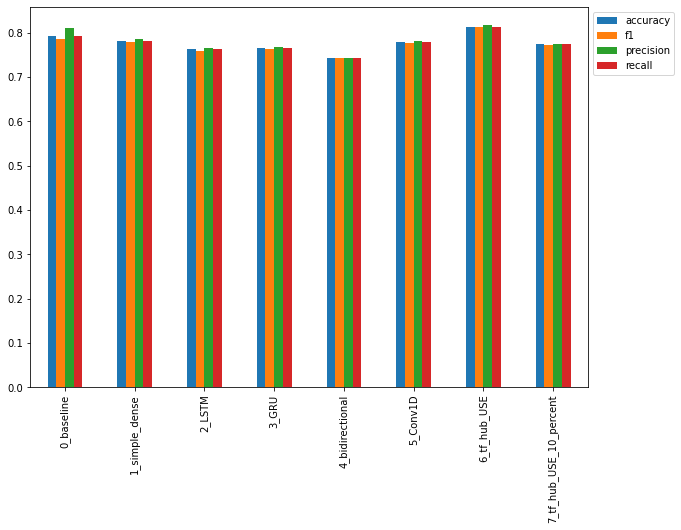

In [ ]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0))

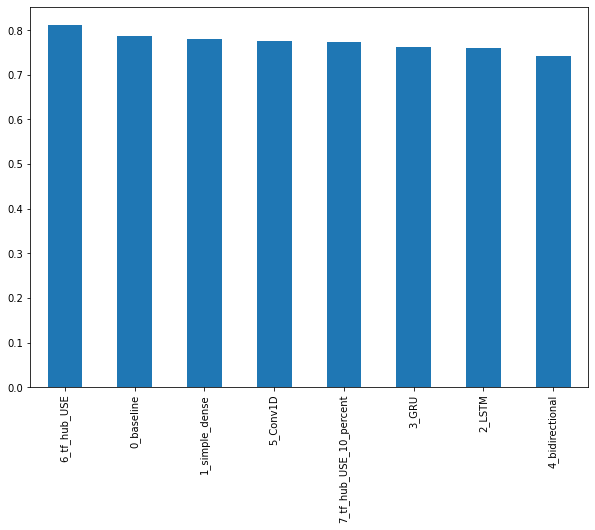

In [ ]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7))

## Uploading our model training logs to TensorBoard.dev

We can further inspect our model's performance using https://tensorboard.dev.

In [ ]:
# View TensorBoard logs for all modelling experiments so far
!tensorboard dev upload --logdir /content/model_logs \
  --name "NLP Modelling Experiments" \
  --description "Comparing multiple different types of model architectures on the Kaggle Tweets text classification dataset" \
  --one_shot

TensorBoard can be viewed here: https://tensorboard.dev/experiment/Xw4EdeWpT2K17PLZ2hWSXw/

In [ ]:
# See the previous TensorBoard Dev experiments you've run
# !tensorboard dev list

## Saving and loading a trained model

There are two main formats to save a model to in TensorFlow:
1. The HDF5 format
2. The `SavedModel` format (this is the default when using TensorFlow)

Refer to this guide: https://www.tensorflow.org/tutorials/keras/save_and_load

In [ ]:
# Save TF Hub USE model to HDF5 format
model_6.save("model_6.h5")

In [ ]:
# Load model with custom Hub Layer (required for HDF5 format)
import tensorflow_hub as hub
loaded_model_6_HDF5_format = tf.keras.models.load_model("model_6.h5",
                                                        custom_objects={"KerasLayer": hub.KerasLayer})

In [ ]:
# How does our loaded model perform?
loaded_model_6_HDF5_format.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 16ms/step - loss: 0.4298 - accuracy: 0.8136


[0.42978182435035706, 0.8136482834815979]

In [ ]:
model_6_results

{'accuracy': 81.36482939632546,
 'f1': 0.8116306237412022,
 'precision': 0.8174785156553263,
 'recall': 0.8136482939632546}

Now let's save to the `SavedModel` format.

In [ ]:
# Save the TF Hub USE model to SavedModel format (default)
model_6.save("model_6_SavedModel_format")

INFO:tensorflow:Assets written to: model_6_SavedModel_format/assets


INFO:tensorflow:Assets written to: model_6_SavedModel_format/assets


In [ ]:
# Load model from SavedModel format
loaded_model_6_SavedModel_format = tf.keras.models.load_model("model_6_SavedModel_format")

In [ ]:
# Evaluat model in SavedModel format
loaded_model_6_SavedModel_format.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 15ms/step - loss: 0.4298 - accuracy: 0.8136


[0.42978182435035706, 0.8136482834815979]

## Finding the most wrong examples

* If our best model still isn't perfect, what examples is it getting wrong?
* Of these wrong examples, which ones is it getting *most* wrong (those with prediction probabilities closest to the opposite class)?

For example, if a sample should have a label of 0 but our model predicts a prediction probability of 0.999 (close to 1) and vice versa.

In [ ]:
# Download a pretrained model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
!unzip 08_model_6_USE_feature_extractor.zip

--2022-04-27 14:53:43--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.8.128, 74.125.23.128, 74.125.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.8.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip’

08_model_6_USE_feat 100%[===================>] 916.27M  38.7MB/s    in 16s     

2022-04-27 14:53:59 (57.6 MB/s) - ‘08_model_6_USE_feature_extractor.zip’ saved [960779165/960779165]

Archive:  08_model_6_USE_feature_extractor.zip
   creating: 08_model_6_USE_feature_extractor/
   creating: 08_model_6_USE_feature_extractor/assets/
   creating: 08_model_6_USE_feature_extractor/variables/
  inflating: 08_model_6_USE_feature_extractor/variables/variables.data-00000-of-00001  
  inflating: 08_model_6_USE_feature_extractor/variables/variables.inde

In [ ]:
# Import previously trained model from Google Storage
model_6_pretrained = tf.keras.models.load_model("08_model_6_USE_feature_extractor")
model_6_pretrained.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 15ms/step - loss: 0.4272 - accuracy: 0.8163


[0.42723119258880615, 0.8162729740142822]

In [ ]:
# Make predictions with the loaded model from GS
model_6_pretrained_pred_probs = model_6_pretrained.predict(val_sentences)
model_6_pretrained_preds = tf.squeeze(tf.round(model_6_pretrained_pred_probs))

In [ ]:
# Create DataFrame with validation sentences, validation labels and best performing model prediction labels + probabilities
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_pretrained_preds,
                       "pred_prob": tf.squeeze(model_6_pretrained_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.159757
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.747162
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988749
3,@camilacabello97 Internally and externally scr...,1,0.0,0.196229
4,Radiation emergency #preparedness starts with ...,1,1.0,0.707808


Let's remind ourselves of the target labels:
* `0` = not disaster
* `1` = disaster

In [ ]:
# Find the wrong predictions and sort by pred_prob
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong.head()

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910196
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
628,@noah_anyname That's where the concentration c...,0,1.0,0.852300
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.835454
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.827213


> Those whose predictions are 1 when it should be 0 are called false positives.

In [ ]:
most_wrong.tail()

,text,target,pred,pred_prob
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.043918
233,I get to smoke my shit in peace,1,0.0,0.042087
38,Why are you deluged with low self-image? Take ...,1,0.0,0.038998
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.038949
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.037186


> Those whose predictions are 0 when it should be 1 are called false negatives.

In [ ]:
# Check the false positives (model predictied 1 when should have been 0)
for row in most_wrong[:10].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Prediction: {pred}, Probability: {pred_prob}")
  print(f"Text: {text}")
  print(f"---\n")

Target: 0, Prediction: 1.0, Probability: 0.9101957678794861
Text: ? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying
---

Target: 0, Prediction: 1.0, Probability: 0.8769820928573608
Text: FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J
---

Target: 0, Prediction: 1.0, Probability: 0.8523001074790955
Text: @noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.
---

Target: 0, Prediction: 1.0, Probability: 0.8354544043540955
Text: Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0
---

Target: 0, Prediction: 1.0, Probability: 0.8272132873535156
Text: @AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should listen to the Americans.
---

Target: 0, Prediction: 1.0, Probability: 0.8148158192634583
Text: @SonofLiberty357 all ill

In [ ]:
# Check the false negatives (model predictied 0 when should have been 1)
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Prediction: {pred}, Probability: {pred_prob}")
  print(f"Text: {text}")
  print(f"---\n")

Target: 1, Prediction: 0.0, Probability: 0.06730346381664276
Text: @DavidVonderhaar At least you were sincere ??
---

Target: 1, Prediction: 0.0, Probability: 0.055075809359550476
Text: @willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu
---

Target: 1, Prediction: 0.0, Probability: 0.05460337549448013
Text: Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets
---

Target: 1, Prediction: 0.0, Probability: 0.054596975445747375
Text: going to redo my nails and watch behind the scenes of desolation of smaug ayyy
---

Target: 1, Prediction: 0.0, Probability: 0.04963727295398712
Text: You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.
---

Target: 1, Prediction: 0.0, Probability: 0.043918490409851074
Text: @SoonerMagic_ I mean I'm a fan but I don't need a girl

## Making predictions on the test dataset

In [ ]:
# Making predictions on the test dataset and visualising them
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_probs = tf.squeeze(model_6_pretrained.predict([test_sample])) # our model expects a list as input
  preds = tf.round(pred_probs)
  print(f"Prediction: {int(preds)}, Probability: {pred_probs}")
  print(f"Text: {test_sample}")
  print(f"---\n")

Prediction: 1, Probability: 0.9301503300666809
Text: #Winston #salem Fire in Pisgah National Forest grows to 375 acres http://t.co/5IMxNGsaSA
---

Prediction: 1, Probability: 0.8783755898475647
Text: Let's appreciate that the group of people that everyone hates so much the police prevented mass casualties today in Nashville.
---

Prediction: 0, Probability: 0.23229077458381653
Text: This #NBCTheWiz cast is about to destroy tv sets across the nation!!!!
---

Prediction: 0, Probability: 0.1856146901845932
Text: @Kayhow21 I may have a panic attack during this coinflip
---

Prediction: 0, Probability: 0.28774139285087585
Text: I liked a @YouTube video http://t.co/18aAsFMVbl Call Of Duty Ghosts Walktrough Part-8 Tsunami!
---

Prediction: 0, Probability: 0.05474871024489403
Text: @JohnnieGuilbert jump off a cliff. I'll be cheering for you to do a back flip for fucks sake. I hope you fall and break your neck.
---

Prediction: 1, Probability: 0.8767529129981995
Text: Refugio oil spill may have

## The speed/score tradeoff

In [ ]:
# Let's make a function to measure the time of prediction
import time
def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on samples.
  """
  start_time = time.perf_counter() # get start time
  model.predict(samples) # make predictions
  end_time = time.perf_counter() # get end time
  total_time = end_time - start_time # calculate how long predictions took to make
  time_per_pred = total_time/len(samples)
  return total_time, time_per_pred

In [ ]:
# Calculate TF Hub USE time per pred
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model_6_pretrained, val_sentences)
model_6_total_pred_time, model_6_time_per_pred

(0.36819422399992163, 0.0004831945196849365)

In [ ]:
# Calculate our baseline model times per pred
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.02675948499995684, 3.511743438314546e-05)

In [ ]:
model_6_total_pred_time / baseline_total_pred_time

13.759391258857018

> The baseline model `model_0` made predictions 18x faster than `model_6`.

In [ ]:
model_6_pretrained_results = evaluate_predictions(model_6_pretrained, val_sentences, val_labels)

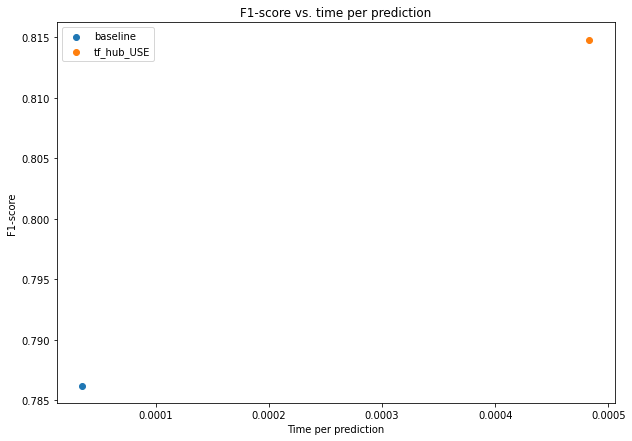

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_pretrained_results["f1"], label="tf_hub_USE")
plt.legend()
plt.title("F1-score vs. time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-score");

# Exercises

## Exercise 1

Rebuild, compile and train `model_1`, `model_2` and `model_5` using the [Keras Sequential API](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) instead of the Functional API.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential

In [ ]:
# model_1 is a simple dense model
model_1_sequential = Sequential([
  layers.Input(shape=(1,), dtype=tf.string),
  text_vectorizer,
  embedding,
  layers.GlobalAveragePooling1D(),
  layers.Dense(1, activation="sigmoid")
])

model_1_sequential.compile(loss="binary_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

model_1_sequential.fit(train_sentences,
                       train_labels,
                       epochs=5,
                       validation_data=(val_sentences, val_labels))

Epoch 1/5
215/215 [==============================] - 2s 8ms/step - loss: 0.5166 - accuracy: 0.8410 - val_loss: 0.4948 - val_accuracy: 0.7848
Epoch 2/5
215/215 [==============================] - 1s 6ms/step - loss: 0.3375 - accuracy: 0.8859 - val_loss: 0.4566 - val_accuracy: 0.7953
Epoch 3/5
215/215 [==============================] - 1s 7ms/step - loss: 0.2679 - accuracy: 0.9067 - val_loss: 0.4615 - val_accuracy: 0.7900
Epoch 4/5
215/215 [==============================] - 1s 7ms/step - loss: 0.2260 - accuracy: 0.9209 - val_loss: 0.4806 - val_accuracy: 0.7874
Epoch 5/5
215/215 [==============================] - 1s 7ms/step - loss: 0.1956 - accuracy: 0.9330 - val_loss: 0.4957 - val_accuracy: 0.7822


In [ ]:
model_1_sequential_results = evaluate_predictions(model_1_sequential, val_sentences, val_labels)
model_1_sequential_results

{'accuracy': 78.21522309711287,
 'f1': 0.7795215466562155,
 'precision': 0.7856661242905698,
 'recall': 0.7821522309711286}

In [ ]:
# model 2 is a LSTM model
model_2_sequential = Sequential([
  layers.Input(shape=(1,), dtype=tf.string),
  text_vectorizer,
  layers.Embedding(input_dim=max_vocab_length,
                   output_dim=128,
                   embeddings_initializer="uniform",
                   input_length=max_length),
  layers.LSTM(64),
  layers.Dense(1, activation="sigmoid")
])

model_2_sequential.compile(loss="binary_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

model_2_sequential.fit(train_sentences,
                       train_labels,
                       epochs=5,
                       validation_data=(val_sentences, val_labels))

Epoch 1/5
215/215 [==============================] - 5s 13ms/step - loss: 0.5084 - accuracy: 0.7494 - val_loss: 0.4560 - val_accuracy: 0.7808
Epoch 2/5
215/215 [==============================] - 2s 10ms/step - loss: 0.3163 - accuracy: 0.8716 - val_loss: 0.4633 - val_accuracy: 0.7795
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.2160 - accuracy: 0.9206 - val_loss: 0.6056 - val_accuracy: 0.7703
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.1538 - accuracy: 0.9458 - val_loss: 0.5931 - val_accuracy: 0.7730
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.1100 - accuracy: 0.9607 - val_loss: 0.7570 - val_accuracy: 0.7703


In [ ]:
model_2_sequential_results = evaluate_predictions(model_2_sequential, val_sentences, val_labels)
model_2_sequential_results

{'accuracy': 77.03412073490814,
 'f1': 0.767494001182533,
 'precision': 0.7735977894089,
 'recall': 0.7703412073490814}

In [ ]:
# model 5 is a Conv1D model
model_5_sequential = Sequential([
  layers.Input(shape=(1,), dtype=tf.string),
  text_vectorizer,
  layers.Embedding(input_dim=max_vocab_length,
                   output_dim=128,
                   embeddings_initializer="uniform",
                   input_length=max_length),
  layers.Conv1D(filters=64,
                kernel_size=5,
                strides=1,
                activation="relu",
                padding="valid"),
  layers.GlobalMaxPool1D(),
  layers.Dense(1, activation="sigmoid")
])

model_5_sequential.compile(loss="binary_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

model_5_sequential.fit(train_sentences,
                       train_labels,
                       epochs=5,
                       validation_data=(val_sentences, val_labels))

Epoch 1/5
215/215 [==============================] - 3s 9ms/step - loss: 0.5535 - accuracy: 0.7205 - val_loss: 0.4680 - val_accuracy: 0.7808
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.3326 - accuracy: 0.8647 - val_loss: 0.4866 - val_accuracy: 0.7822
Epoch 3/5
215/215 [==============================] - 2s 7ms/step - loss: 0.2045 - accuracy: 0.9260 - val_loss: 0.5535 - val_accuracy: 0.7703
Epoch 4/5
215/215 [==============================] - 2s 7ms/step - loss: 0.1283 - accuracy: 0.9580 - val_loss: 0.6461 - val_accuracy: 0.7717
Epoch 5/5
215/215 [==============================] - 2s 7ms/step - loss: 0.0917 - accuracy: 0.9717 - val_loss: 0.7076 - val_accuracy: 0.7677


In [ ]:
model_5_sequential_results = evaluate_predictions(model_5_sequential, val_sentences, val_labels)
model_5_sequential_results

{'accuracy': 76.77165354330708,
 'f1': 0.766696834597351,
 'precision': 0.7676331847037146,
 'recall': 0.7677165354330708}

## Exercise 2

Retrain the baseline model with 10% of the training data. How does it perform compared to the Universal Sentence Encoder model with 10% of the training data?

In [ ]:
# Create baseline model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0_10_percent = Pipeline([
                               ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                               ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to 10% of the training data
model_0_10_percent.fit(train_sentences_10_percent, train_labels_10_percent)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evaluate our baseline model
baseline_score_10_percent = model_0_10_percent.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score_10_percent*100:.2f}%")

Our baseline model achieves an accuracy of: 70.21%


In [ ]:
model_7_results["accuracy"]

77.42782152230971

The baseline model (`model_0_10_percent`) when trained on 10% of the training data performed much **worse** than the Universal Sentence Encoder model (`model_7`) when trained on 10% of the training data.

## Exercise 3

Try fine-tuning the TF Hub Universal Sentence Encoder model by setting `training=True` when instantiating it as a Keras layer.

In [ ]:
# Set sentence_encoder_layer to trainable
import tensorflow as tf
import tensorflow_hub as hub
sentence_encoder_layer_fine_tuning = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                                    input_shape=[],
                                                    dtype=tf.string,
                                                    trainable=True)

In [ ]:
# Recreate model_6
from tensorflow import keras
from tensorflow.keras import layers, Sequential
model_6_fine_tuning = Sequential([
  sentence_encoder_layer_fine_tuning,
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid")
])

# Compile the model
model_6_fine_tuning.compile(loss="binary_crossentropy",
                            optimizer=tf.keras.optimizers.Adam(),
                            metrics=["accuracy"])

In [ ]:
# Fit the model
model_6_fine_tuning.fit(train_sentences,
                         train_labels,
                         epochs=5,
                         validation_data=(val_sentences, val_labels))

Epoch 1/5
215/215 [==============================] - 60s 245ms/step - loss: 0.4514 - accuracy: 0.8012 - val_loss: 0.4028 - val_accuracy: 0.8281
Epoch 2/5
215/215 [==============================] - 55s 257ms/step - loss: 0.2322 - accuracy: 0.9114 - val_loss: 0.4779 - val_accuracy: 0.8268
Epoch 3/5
215/215 [==============================] - 53s 247ms/step - loss: 0.0773 - accuracy: 0.9750 - val_loss: 0.5611 - val_accuracy: 0.7900
Epoch 4/5
215/215 [==============================] - 54s 250ms/step - loss: 0.0417 - accuracy: 0.9850 - val_loss: 0.6350 - val_accuracy: 0.7717
Epoch 5/5
215/215 [==============================] - 52s 240ms/step - loss: 0.0277 - accuracy: 0.9889 - val_loss: 0.7141 - val_accuracy: 0.8163


In [ ]:
model_6_fine_tuning_results = evaluate_predictions(model_6_fine_tuning, val_sentences, val_labels)
model_6_fine_tuning_results

{'accuracy': 81.62729658792651,
 'f1': 0.813022410660206,
 'precision': 0.8252416515568405,
 'recall': 0.8162729658792651}

## Exercise 4

Retrain the best model you've got so far on the whole training set (no validation split). Then use this trained model to make predictions on the test dataset and format the predictions into the same format as the `sample_submission.csv` file from Kaggle (see the Files tab in Colab for what the `sample_submission.csv` file looks like). Once you've done this, [make a submission to the Kaggle competition](https://www.kaggle.com/c/nlp-getting-started/data), how did your model perform?

In [ ]:
# Use the whole training set
whole_train_sentences = train_df_shuffled["text"].to_numpy()
whole_train_labels = train_df_shuffled["target"].to_numpy()

In [ ]:
# Set test data
test_sentences = test_df["text"].to_list()

Since `model_6_fine_tuning` is the best model, we will modify and use it on the whole training set.

In [ ]:
# Create sentence_encoder_layer
import tensorflow as tf
import tensorflow_hub as hub
sentence_encoder_layer_fine_tuning = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                                    input_shape=[],
                                                    dtype=tf.string,
                                                    trainable=True)

In [ ]:
# Create and modify model_6_fine_tuning
from tensorflow import keras
from tensorflow.keras import layers, Sequential
model_submission = Sequential([
  sentence_encoder_layer_fine_tuning,
  layers.Dense(64, activation="relu"),
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid")
])

# Compile the model
model_submission.compile(loss="binary_crossentropy",
                         optimizer=tf.keras.optimizers.Adam(),
                         metrics=["accuracy"])

In [ ]:
# Fit the model
model_submission.fit(whole_train_sentences,
                     whole_train_labels,
                     epochs=5)

Epoch 1/5
238/238 [==============================] - 66s 232ms/step - loss: 0.4512 - accuracy: 0.8006
Epoch 2/5
238/238 [==============================] - 55s 231ms/step - loss: 0.2403 - accuracy: 0.9074
Epoch 3/5
238/238 [==============================] - 55s 232ms/step - loss: 0.0823 - accuracy: 0.9728
Epoch 4/5
238/238 [==============================] - 55s 232ms/step - loss: 0.0437 - accuracy: 0.9842
Epoch 5/5
238/238 [==============================] - 57s 239ms/step - loss: 0.0281 - accuracy: 0.9884


In [ ]:
# Evaluate predictions on validation data
evaluate_predictions(model_submission, val_sentences, val_labels)

{'accuracy': 99.21259842519686,
 'f1': 0.9921200731985449,
 'precision': 0.9922384701912261,
 'recall': 0.9921259842519685}

In [ ]:
# Make predictions with the model
pred_probs = model_submission.predict(test_df["text"].to_numpy())

# Convert prediction probabilities to labels
preds = tf.squeeze(tf.round(pred_probs))
preds = tf.cast(preds, tf.int32)

In [ ]:
test_df

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [ ]:
# Create submission DataFrame
submission = pd.DataFrame({"id":test_df["id"].values,
                           "target":(preds.numpy())})
submission

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [ ]:
# Export submission DataFrame to a .csv file to submit to Kaggle
submission.to_csv("submission.csv", index=False)

My submission on Kaggle had a public score of 0.79834.

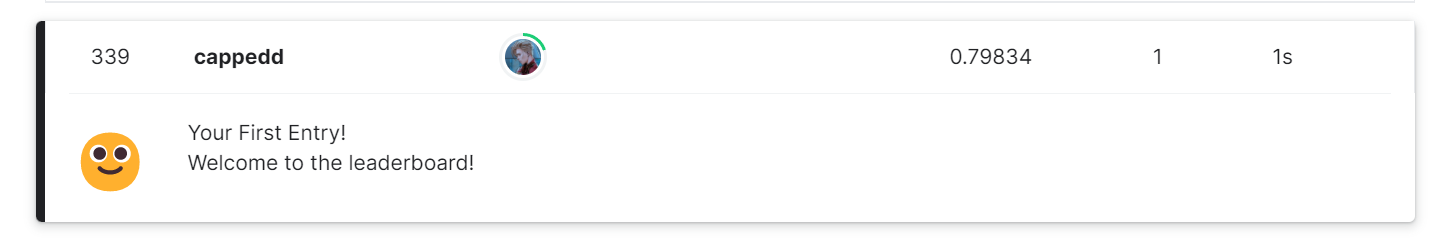

## Exercise 5

Combine the ensemble predictions using the majority vote (mode), how does this perform compared to averaging the prediction probabilities of each model?

In [ ]:
# Prepare test data
test_sentences = test_df["text"].to_numpy()
test_sentences.shape

(3263,)

In [ ]:
# Get model predictions
def get_preds(model, sentences=val_sentences):
  pred_probs = model.predict(sentences)
  preds = tf.squeeze(tf.round(pred_probs))
  preds = tf.cast(preds, tf.int32)

  return preds

In [ ]:
# Get predictions from model 1, 2, 5, 6
model_1_preds = get_preds(model_1)
model_2_preds = get_preds(model_2)
model_5_preds = get_preds(model_5)
model_6_preds = get_preds(model_6)

In [ ]:
# Create a DataFrame of predictions
preds_df = pd.DataFrame({"dense_model": model_1_preds,
                         "LSTM_model": model_2_preds,
                         "Conv1D_model": model_5_preds,
                         "USE_model": model_6_preds})
preds_df.head()

,dense_model,LSTM_model,Conv1D_model,USE_model
0,0,0,1,0
1,1,1,0,1
2,1,1,1,1
3,0,0,0,0
4,0,0,0,1


In [ ]:
# Majority voted predictions of our model
preds_df["majority_voted_preds"] = preds_df.mode(axis=1)[0] # get mode of each row
preds_df

,dense_model,LSTM_model,Conv1D_model,USE_model,majority_voted_preds
0,0,0,1,0,0.0
1,1,1,0,1,1.0
2,1,1,1,1,1.0
3,0,0,0,0,0.0
4,0,0,0,1,0.0
...,...,...,...,...,...
757,0,1,0,0,0.0
758,0,0,0,0,0.0
759,1,1,0,1,1.0
760,0,0,0,1,0.0


In [ ]:
# Convert mode predictions to a numpy array
mode_preds = preds_df["majority_voted_preds"].to_numpy()

TensorShape([762])

In [ ]:
# Evalute mode predictions
calculate_results(val_labels, mode_preds)

{'accuracy': 80.0524934383202,
 'f1': 0.7958480716330087,
 'precision': 0.8131705235318867,
 'recall': 0.800524934383202}

## Exercise 6

Make a confusion matrix with the best performing model's predictions on the validation set and the validation ground truth labels.

The best model is `model_submission`.

In [ ]:
model_submission_pred_probs = model_submission.predict(val_sentences)
model_submission_preds = tf.squeeze(tf.round(model_submission_pred_probs))

In [ ]:
from helper_functions import make_confusion_matrix

In [ ]:
class_names = ["not a disaster", "disaster"]

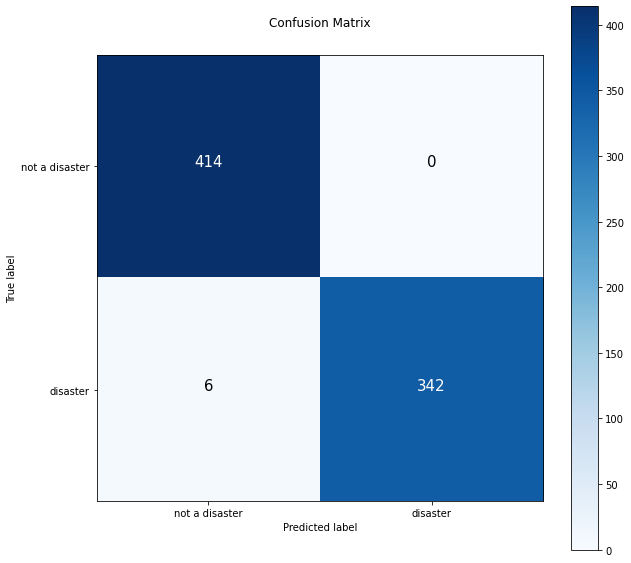

In [ ]:
make_confusion_matrix(y_true=val_labels,
                      y_pred=model_submission_preds,
                      classes=class_names,
                      savefig=True)